In [1]:
from earlyexitnet.training_tools.train import get_model
from earlyexitnet.tools import load_model, CIFAR10DataColl
import torch
import os

model_path = '../../trained_models/b_lenet_cifar10.pth'
model_name = "b_lenet_cifar"
data_set = "cifar10"
device = 'cuda:0'

# model_path = '../../earlyexitnet/trained_models/resnet8_2ee_230721.pth'
# model_name = "resnet8_2ee"
model = get_model(model_name)
load_model(model, model_path, device=torch.device(device))

Model done: b_lenet_cifar


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
#plt.switch_backend('WebAgg')
#%matplotlib widget
import numpy as np

BATCH_SIZE = 5000
TEST_BS = 10000

datacoll = CIFAR10DataColl(batch_size_train=BATCH_SIZE, batch_size_test=TEST_BS, v_split=0.2, num_workers=16, pin_mem=True)

from earlyexitnet.testing_tools.test import Tester
import json
from datetime import datetime as dt


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# run the test now? or load a previous one?
run_test=False
#run_test=True


if run_test:
    #train_dl = datacoll.get_train_dl() # get dataloader
    test_dl = datacoll.get_test_dl() # get dataloader
    
    tester = Tester(model, 
                    #train_dl, 
                    test_dl, 
                    exits=2, 
                    conf_funcs=None, 
                    top1acc_thresholds=[0.65,0],
                    fast_thresholds=[0.46,0],
                    fast_noTrunc_thresholds=[0.50,0],
                    fast_sub_thresholds=[0.39,0],
                    fast_sub_bitAcc_thresholds=[0.39,0],
                    fast_base4_sub_thresholds=[0.56,0],
                    entropy_thresholds=[1.1448, 1000000],
                    device=torch.device(device), save_raw=True)
    
    tester.test()
    
    test_res = tester.get_stats()
    
    # add the model name and dataset
    test_res["model"] = model_name
    test_res["model_path"] = model_path
    test_res["dataset"] = data_set
    
    timestamp = dt.now().strftime("%Y-%m-%d_%H%M%S")
    
    save_path = f'../../model-outputs/{model_name}/'
    save_name = f'cifar10_raw_train_output_{timestamp}.json'
    full_dest = os.path.join(save_path, save_name)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    with open(full_dest,'w') as file:
            file.write(json.dumps(test_res))
else:
    # uses 80% of the training data
    #json_file = f'../../model-outputs/{model_name}/cifar10_raw_train_output_2025-01-21_145159.json'

    # uses 100% of the test data
    json_file = f'../../model-outputs/{model_name}/cifar10_raw_train_output_2025-01-23_122425.json'
    full_dest = json_file
    with open(json_file) as json_data:
        test_res = json.load(json_data)

In [4]:
# load the raw outputs from the model
raw_results = torch.Tensor(test_res['raw_layer'])
# load the ground truth index for each class
ground_truth = torch.Tensor(test_res['true_indices'])

# compare the results to the ground truth, provides bool mask
correct_predictions = (raw_results.argmax(-1) == ground_truth)
# 2 exits by num inputs, 2 exits by num samples by last linear layer output(NOT sftmax)
correct_predictions.shape, raw_results.shape

(torch.Size([2, 10000]), torch.Size([2, 10000, 10]))

In [5]:
import earlyexitnet.data_analysis.graphs as hp

classes_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

conf_list = [
        "_thr_entropy",
        "_thr_max_softmax",
        "_thr_max_softmax_fast",
        "_thr_max_softmax_fast_noTrunc",
        "_thr_max_softmax_fast_sub",
        "_thr_max_softmax_fast_sub_bitAcc"
]
#top1_sftmx = torch.Tensor(test_res['conf_metrics']['_thr_max_softmax']['raw_softmax'])

rr = raw_results.numpy() # [exits, batch size, class dist]

# individual inputs raw results over 10 classes seems to get spread across the indices
# meaning that the 0,0,0 = 0,0 BUT 0,0,1 = 0,40000
# this has the effect of grouping each logit index with the others, duplicating a lot of info

#flattened = rr.swapaxes(1,2).reshape(2,-1)
#chosen_class = np.concatenate((rr.argmax(-1).copy(), rr.argmax(-1).copy()), axis=-1)
#index = np.concatenate((np.full((2,40000), 0), np.full((2,40000), 1)), axis=-1)
#correct_classif = np.concatenate((correct_predictions, correct_predictions), axis=-1)
#for i in range(10-2):
#    chosen_class = np.concatenate(
#        (chosen_class, rr.argmax(-1)), axis=-1
#    )
#    index = np.concatenate(
#        (index, np.full((2,40000), i+2)), axis=-1
#    )
#    correct_classif = np.concatenate(
#        (correct_classif, correct_predictions), axis=-1
#    )

# [class index of this raw value from logit, raw logit value, chosen class (from argmax), misclassified (0 is incorrect, 1 is correct)
#comb = np.stack(
#    (index, flattened, chosen_class, correct_classif), -1
#)

#classes_grouped = hp.group_by(comb)

In [6]:
#import helper.graphs as hp
#%matplotlib widget
#from importlib import reload
#reload(hp)

#early_exit = classes_grouped[0]
# print(early_exit[0])
num_exits=2
num_classes=10

#fig, ax_grp = plt.subplots(nrows=10,ncols=2, sharex=True, sharey=True)
#print("")

#for k, ex in enumerate(classes_grouped):
#    for i, rec_class in enumerate(ex):
#        # set ax to be working on
#        ax = ax_grp[i][k]
#        # make numpy array
#        rec_class = np.array(rec_class)
#        # plot all values produce by single class output
#        hp.plot_right_wrong(ax, np.array(rec_class[:,0]),(np.array(rec_class[:,1]) == i), quants=None)

#        # hmm not sure exactly what this is doing
#        wrong_class = rec_class[np.invert(np.array(rec_class[:,2],dtype=bool))]
#        ismax = np.array(wrong_class[:,1]) == i
#        #hp.plot_hist_kernel(ax, wrong_class[:,0][ismax], label=f"{i} {classes_labels[i]} wrong", hist=False)

#        # hmm not sure exactly what this is doing
#        right_class = rec_class[np.array(rec_class[:,2],dtype=bool)]
#        ismax = np.array(right_class[:,1]) == i
#        #hp.plot_hist_kernel(ax, right_class[:,0][ismax], label=f"{i} {classes_labels[i]} right", hist=False, ls='-')
        
#        ax.set_title(f"{i} {classes_labels[i]}")
#        ax.legend()
#fig.set_size_inches(10 * num_exits, 4 * num_classes)
#fig.tight_layout()
#plt.show()

# some observations - deer and cat are the hardest classes judging by the amount of overlap 
# future work is per-class thresholds

In [7]:
# SHOW THE MODEL WORKING
# %matplotlib ipympl needs ipywidgets
import math
from IPython.core.debugger import set_trace

test_dl = datacoll.get_test_dl()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, ncols=1, label=None, caption=None):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.to('cpu').numpy()
    num_img = npimg.shape[0]
    
    nrows = math.ceil(num_img / ncols)
    
    img_track = 0
    
    for row in range(nrows):
        fig, axs = plt.subplots(nrows=1, ncols=ncols,
                                subplot_kw={'xticks': [], 'yticks': []})

        if row > 5:
            break
        
        for ax in axs:
            if img_track < num_img:
                ax.imshow(np.transpose(npimg[img_track], (1, 2, 0)))
                if label is not None:
                    ax.set_title(label[img_track])
                if caption is not None:
                    ax.set_xlabel(caption[img_track])
            img_track += 1
            
        plt.tight_layout()
        # plt.imshow(np.transpose(npimg, (1, 1, 1)))
        plt.show()

def getcaption(images, model):
    model.eval()
    #captions = ['' for i in range(BATCH_SIZE)]
    captions = ['' for i in range(10)]
    with torch.no_grad():
        result = model.forward(images)
        sftmx = torch.max(torch.softmax(result, dim=-1),dim=-1).values
        res_max = result.max(dim=-1).values
        res_arg_max = result.max(dim=-1).indices
        for exit_num, (max, arg_max) in enumerate(zip(sftmx, res_arg_max)):
            for i, (max_val, index) in enumerate(zip(max, arg_max)):
                captions[i] += f"e{exit_num} {classes[index]:5s} {max_val:.02f}"
                if exit_num != model.exit_num - 1:
                    captions[i] += '\n'
    return captions
# get some random training images
dataiter = iter(test_dl)
images, labels = next(dataiter)
images.shape, labels.shape
images[:10].shape, labels[:10]



if run_test:
    images = images[:10].to(device)
    labels = labels[:10].to(device)
else:
    images = images[:10]
    labels = labels[:10]

# show images
#imshow(images, ncols=5, label=[f'{classes[label]:5s}' for label in labels], caption=getcaption(images, model))


Running analysis on different confidence functions
Confidence function 0: entropy
Confidence function 1: max_softmax
Confidence function 2: max_softmax_fast
Confidence function 3: max_softmax_fast_noTrunc
Confidence function 4: max_softmax_fast_sub
Found a sub! max_softmax_fast_sub
Confidence function 5: max_softmax_fast_sub_bitAcc
Found a sub! max_softmax_fast_sub_bitAcc


/home/bb2515/miniconda3/envs/ee_gpu_py39/lib/python3.10/site-packages/earlyexitnet/data_analysis/softmax_comparison.py:463: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


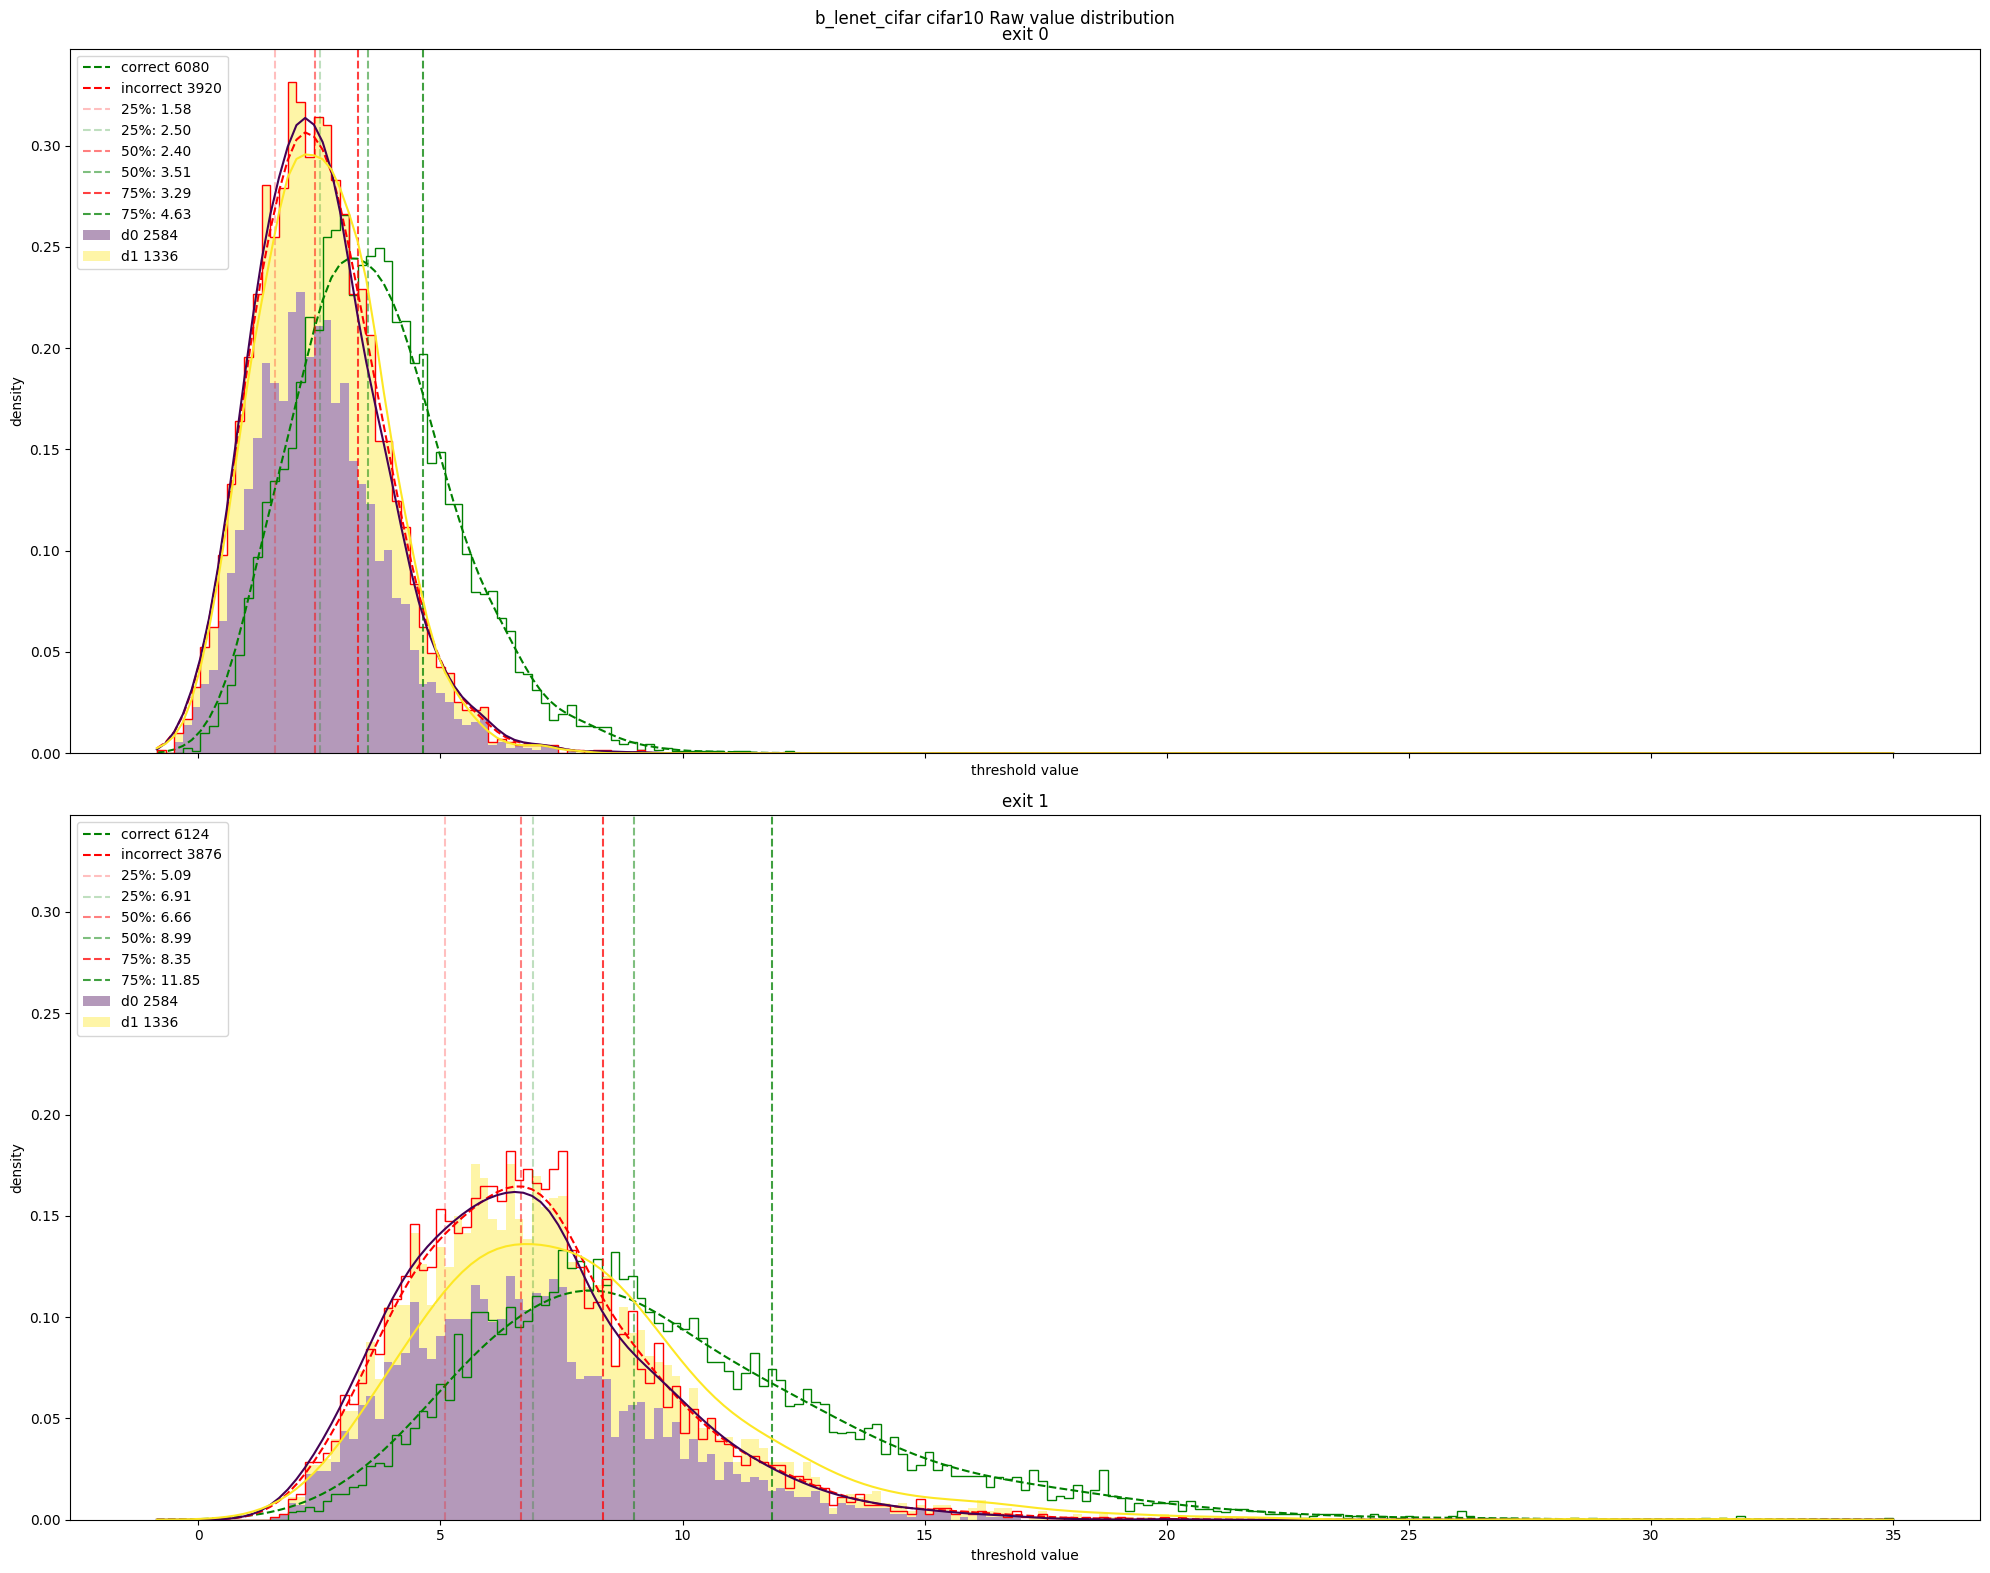

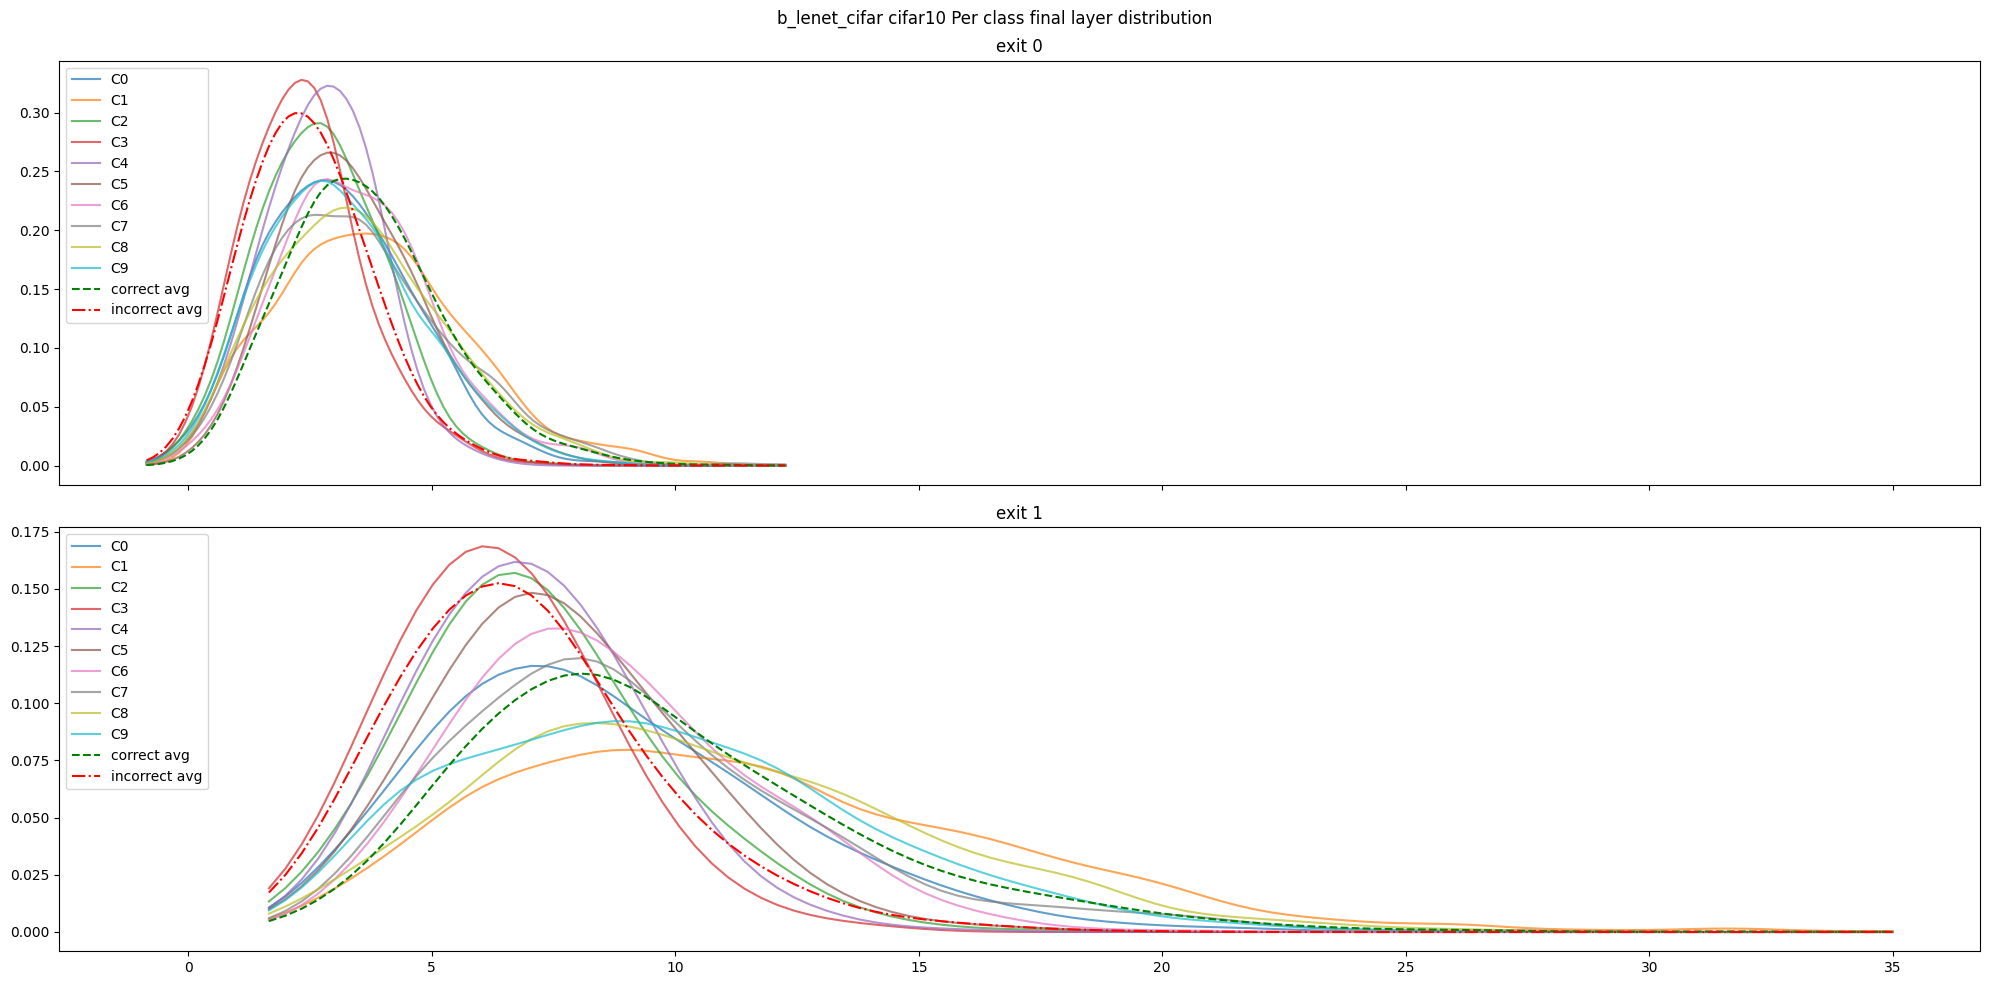

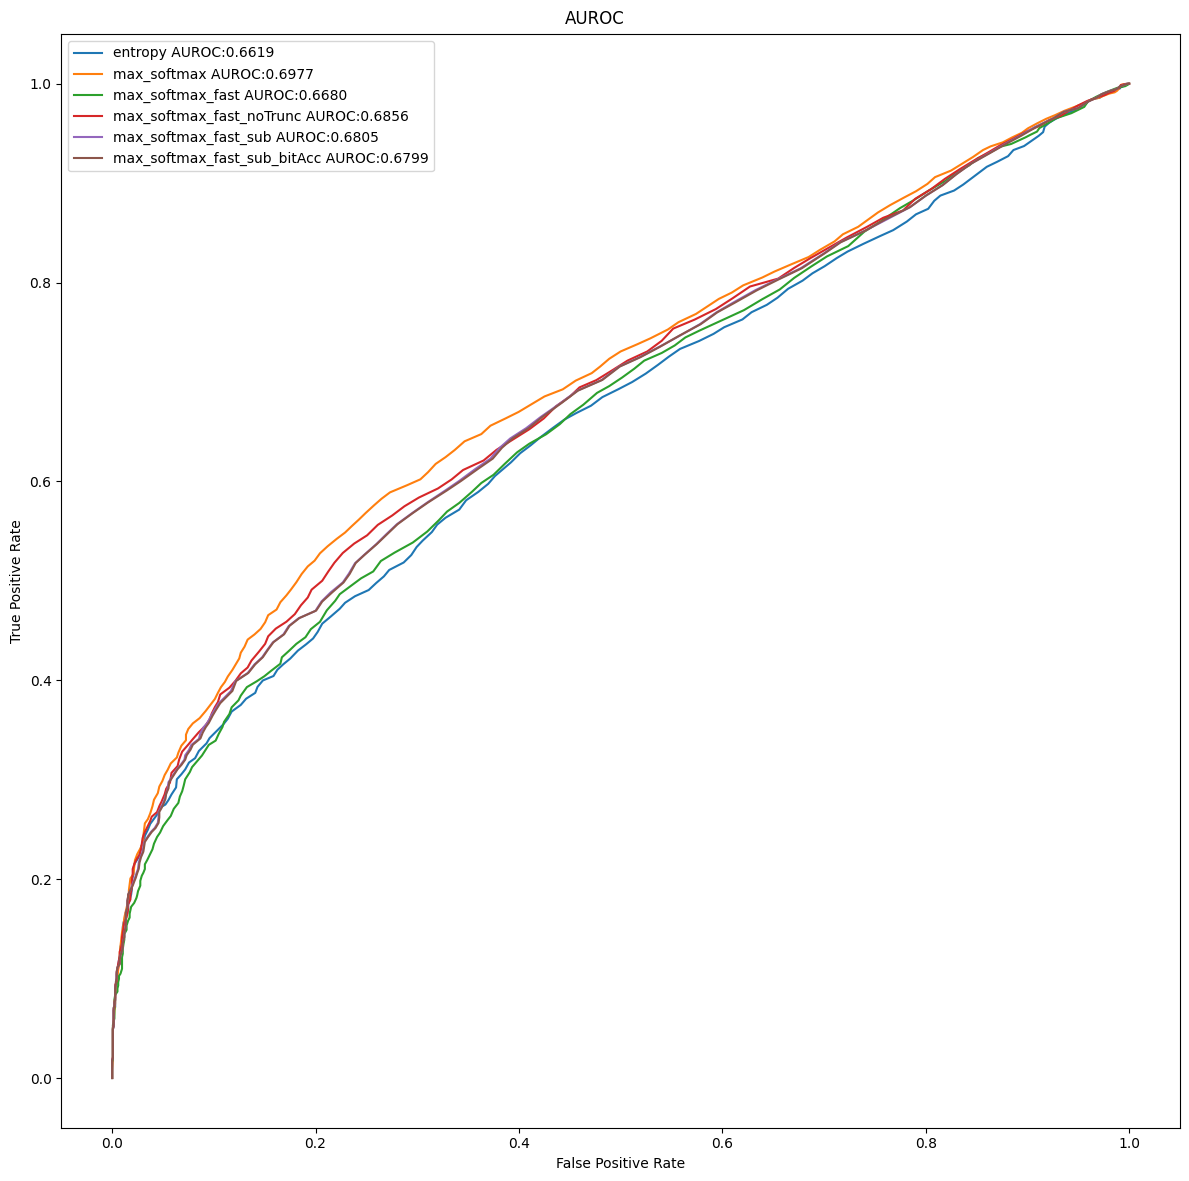

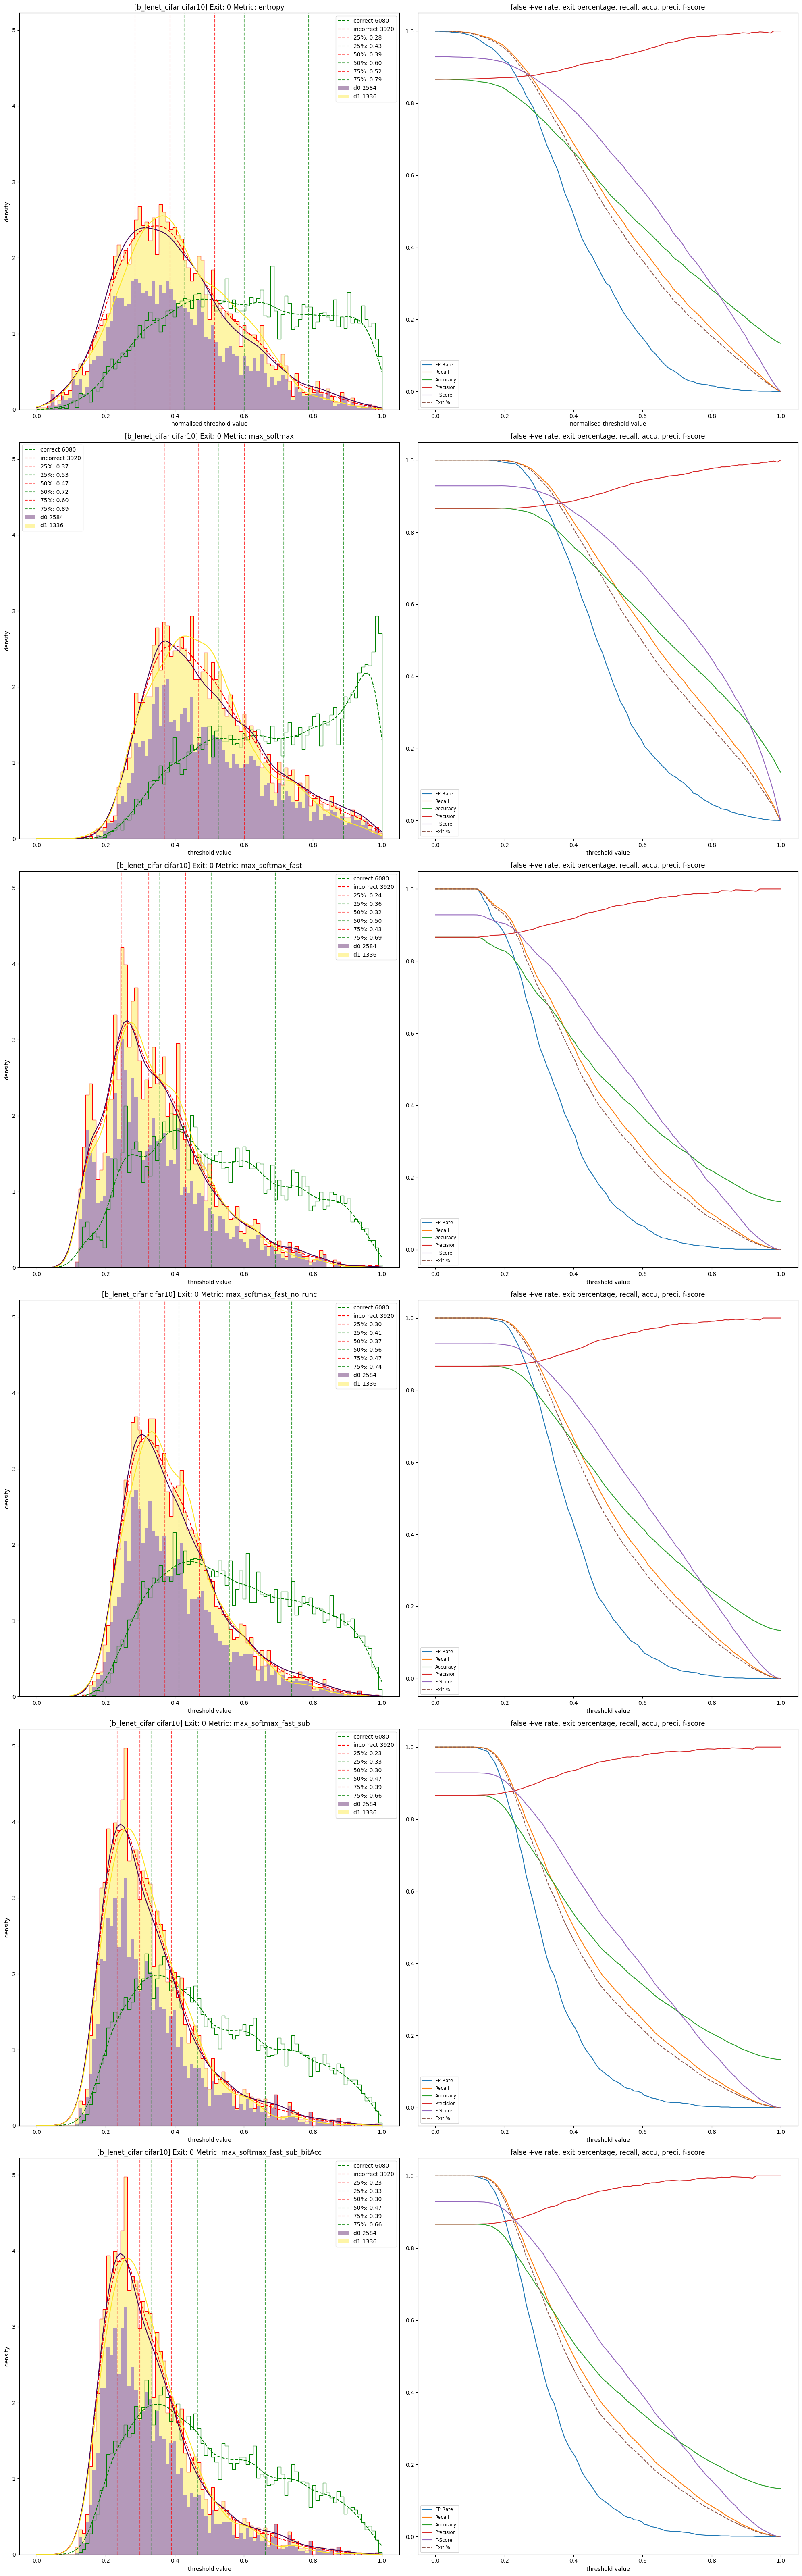

In [8]:
# Checking to see if there is some code to reuse in data_analysis

from earlyexitnet.data_analysis.softmax_comparison import main as sftmxcmp_main

sftmxcmp_main(full_dest) #funcs=None, plot_classes=False <- defaults


In [9]:
##### Confusion matrix #####
# (my version at least)

# quadrant definitions:
# tp, true positive - when an early exit occurs and the classification is correct
# fp, false positive - when an early exit occurs and the classification is incorrect
    # query - do I include ee=true && ee_c == fe_c, ee classif equals final exit classif
    # in that case it is positive since avoid wasting compute on something that will be wrong anyway?
    # maybe the above should go in true +ve
# tn, true negative - when an early exit DOES NOT OCCUR and the classification is wrong
    # similar query - does tn include ee=false && ee_c == fec or does that go in tp??
# fn, false negative - ee=false && ee_c == correct
    # query - this is bad but even worse is the case: ee=false && ee_c == correct && fe_c != correct

conf_list = [
        "_thr_entropy",
        "_thr_max_softmax",
        "_thr_max_softmax_fast",
        "_thr_max_softmax_fast_noTrunc",
        "_thr_max_softmax_fast_sub",
        "_thr_max_softmax_fast_sub_bitAcc"
]

print(test_res.keys())
print(f"accuracy per exit:{test_res['accu_per_exit']}")

for conf in test_res['conf_metrics'].keys():
    if 'base4' in conf:
        continue
    print(f"conf metric stats: {conf}")
    for k in test_res['conf_metrics'][conf].keys():
        if k == 'raw_softmax':
            continue
        print(f"\t{k} :\t{test_res['conf_metrics'][conf][k]}")

standard_softmax = torch.tensor(test_res['conf_metrics']['_thr_max_softmax']['raw_softmax'])
#print(standard_softmax.shape)

pow2_truc_softmax = torch.tensor(test_res['conf_metrics']["_thr_max_softmax_fast"]['raw_softmax'])
#print(pow2_truc_softmax.shape)

# simple check to see if they pick the same values
std_sft_ee_cl = standard_softmax[0].argmax(-1)
#print(std_sft_ee_cl)

p2tr_sft_ee_cl = pow2_truc_softmax[0].argmax(-1)
#print(p2tr_sft_ee_cl)

# sanity checking that there is a difference between two conf functions
diff_idx = []
for i, (std, p2tr) in enumerate(zip(std_sft_ee_cl, p2tr_sft_ee_cl)):
    if std != p2tr:
        # get the sample number within the batch in which the values differ
        # doesn't necessarily mean that the classif will be different?
        diff_idx.append(i)

diff_idx_tensor = torch.tensor(diff_idx)
diff_idx_tensor.shape

# There is difference! 
# I reckon this is from the truncation, two class values are very close to each other
# same order of magnitude but with one slightly higher, selection will default to the lowest index
# same thing would happen in HW I assume

# will be interesting to see if this results in a significant accuracy change or not
# it is quite a lot of samples? but probably depends on how good the classifier is anyway

#print(test_res.keys())
#print(test_res['conf_metrics'].keys())
#print(test_res['conf_metrics']['_thr_entropy'].keys())

#subting = torch.tensor(test_res['conf_metrics']['_thr_max_softmax_fast_sub']['raw_softmax'])
#print(standard_softmax.argmax(-1))
#print(pow2_truc_softmax.argmax(-1))
#subting.argmax(-1)

# determine "best" thr for sub
bitAcc_sub_sftmx = torch.tensor(test_res['conf_metrics']["_thr_max_softmax_fast_sub_bitAcc"]['raw_softmax'])
entr_vals = torch.tensor(test_res['conf_metrics']["_thr_entropy"]['raw_softmax'])
# get the summations
cumul = bitAcc_sub_sftmx.sum(axis=-1)
# get the max of each of these sums
summax = cumul.max()
entr_max = entr_vals.max()
print(summax, entr_max)

# value of 50% scaled back to a sum
converted_thr = 1/((1-0.71)*summax)
converted_entr_thr = 0.51 * entr_max

#1 > thr * sum -> thr < 1/sum
# 1 > thr * (sum/max)

print(converted_thr, converted_entr_thr)

###########################################

# hopefully now we have the best thrs?
# yes: 1.1448, 0.46, 0.5, 0.39, 0.39

# so for each of the conf metrics (include entropy?)

correct_idxs = torch.tensor(test_res['true_indices'])
ee_classif_idx = torch.tensor(test_res['raw_layer'])[0].max(axis=-1).indices
fe_classif_idx = torch.tensor(test_res['raw_layer'])[1].max(axis=-1).indices

ee_corr_mask = ee_classif_idx.eq(correct_idxs)
fe_corr_mask = fe_classif_idx.eq(correct_idxs)
print(ee_corr_mask.shape, fe_corr_mask.shape, ee_corr_mask.sum(), fe_corr_mask.sum(), )
total = len(correct_idxs)

for conf in test_res['conf_metrics'].keys():
    if 'base4' in conf:
        continue
    print(f"conf metric: {conf}")
    # get the raw data
    raw_ee = torch.tensor(test_res['conf_metrics'][conf]['raw_softmax'])[0]
    raw_fe = torch.tensor(test_res['conf_metrics'][conf]['raw_softmax'])[1]
    # get the early exit thr
    ee_thr = test_res['conf_metrics'][conf]['exit_threshs'][0]
    print(ee_thr, type(ee_thr))

    # do the right decision depending on metric
    if 'entropy' in conf:
        # if val is less than ee_thr
        ee_true_mask = raw_ee.lt(ee_thr)
    elif 'sub' in conf:
        # if sum * thr is le 1
        raw_summed = raw_ee.sum(axis=-1)
        scaled_sum = raw_summed.multiply(ee_thr)
        ee_true_mask = scaled_sum.le(1)
    else:
        # top1 softmax versions
        raw_maxxed = raw_ee.max(axis=-1).values
        ee_true_mask = raw_maxxed.gt(ee_thr)

    cat_dict = {
        'cat100':[],
        'cat101':[],
        'cat110':[],
        'cat111':[],
        'cat000':[],
        'cat001':[],
        'cat010':[],
        'cat011':[]
        }

    # first things first, put them into 8 bins
    for input_idx, (ee, ee_c, fe_c) in enumerate(zip(ee_true_mask, ee_corr_mask, fe_corr_mask)):
        # is an ee triggered by the best thr?
        if ee:
            # is the ee classification correct?    
            if ee_c:
                # is the final exit classification correct?
                if fe_c:
                    cat_dict['cat111'].append(input_idx)
                else:
                    cat_dict['cat110'].append(input_idx)
                
            else:       
                if fe_c:
                    cat_dict['cat101'].append(input_idx)
                else:
                    cat_dict['cat100'].append(input_idx)
        else:
            if ee_c:
                if fe_c:
                    cat_dict['cat011'].append(input_idx)
                else:
                    cat_dict['cat010'].append(input_idx)
            else:
                if fe_c:
                    cat_dict['cat001'].append(input_idx)
                else:
                    cat_dict['cat000'].append(input_idx)

    for cat in cat_dict.keys():
        cat_dict[cat] = torch.tensor(cat_dict[cat])
        print(f"{cat}: of size {cat_dict[cat].shape[0]}")

    

    tp = cat_dict['cat110'].shape[0] + cat_dict['cat111'].shape[0] + cat_dict['cat100'].shape[0]  # last cat you save compute on what will be wrong anyway
    fp = cat_dict['cat101'].shape[0]
    tn = cat_dict['cat001'].shape[0]
    fn = cat_dict['cat011'].shape[0] + cat_dict['cat010'].shape[0] + cat_dict['cat000'].shape[0] # last cat you save compute on what will be wrong anyway
    print(f"True positives: {tp}, rate: {tp/total}")
    print(f"False positives: {fp}, rate: {fp/total}")
    print(f"True negatives: {tn}, rate: {tn/total}")
    print(f"False negatives: {fn}, rate: {fn/total}")
    recall = tp/(tp+fn)
    accu = (tp+tn)/total
    prec = tp/(tp+fp)
    fm = (2*recall*prec)/(recall+prec)
    print(f"Recall: {recall} (correct | +ve), Accuracy: {accu}, Precision: {prec}, F-score: {fm}")


# quadrant definitions:
# tp, true positive - when an early exit occurs and the classification is correct
# fp, false positive - when an early exit occurs and the classification is incorrect
    # query - do I include ee=true && ee_c == fe_c, ee classif equals final exit classif
    # in that case it is positive since avoid wasting compute on something that will be wrong anyway?
    # maybe the above should go in true +ve
# tn, true negative - when an early exit DOES NOT OCCUR and the classification is wrong
    # similar query - does tn include ee=false && ee_c == fec or does that go in tp??
# fn, false negative - ee=false && ee_c == correct
    # query - this is bad but even worse is the case: ee=false && ee_c == correct && fe_c != correct
    

dict_keys(['conf_metrics', 'num_exits', 'num_samples', 'batch_size', 'accu_per_exit', 'true_indices', 'raw_layer', 'model', 'model_path', 'dataset'])
accuracy per exit:[0.608, 0.6124]
conf metric stats: _thr_entropy
	exit_pc :	[0.5192, 0.4808]
	accu_pc :	[0.7771571648690293, 0.4631863560732113]
	exit_threshs :	[1.1448, 1000000]
	combined_accuracy :	0.6262
conf metric stats: _thr_max_softmax
	exit_pc :	[0.4275, 0.5725]
	accu_pc :	[0.831345029239766, 0.48541484716157207]
	exit_threshs :	[0.65, 0]
	combined_accuracy :	0.6333
conf metric stats: _thr_max_softmax_fast
	exit_pc :	[0.4221, 0.5779]
	accu_pc :	[0.8118929163705283, 0.49108842360269944]
	exit_threshs :	[0.46, 0]
	combined_accuracy :	0.6265
conf metric stats: _thr_max_softmax_fast_noTrunc
	exit_pc :	[0.44, 0.56]
	accu_pc :	[0.8209090909090909, 0.48]
	exit_threshs :	[0.5, 0]
	combined_accuracy :	0.63
conf metric stats: _thr_max_softmax_fast_sub
	exit_pc :	[0.4832, 0.5168]
	accu_pc :	[0.796771523178808, 0.47329721362229105]
	exit_thr